In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import struct
import h5py

def nrnMread(fileName):
    f = open(fileName, "rb")
    nparam = struct.unpack('i', f.read(4))[0]
    typeFlg = struct.unpack('i', f.read(4))[0]
    return np.fromfile(f,np.double)

data_dir ='../Data'


def nrnMreadH5(fileName):
    f = h5py.File(fileName,'r')
    dat = f['Data'][:][0]
    return np.array(dat)

(1, 10000)
10000
(1, 10000)
10000
(1, 10000)
10000
(1, 10000)
10000
(1, 10000)
10000
(1, 10000)
10000
(1, 10000)
10000
(1, 10000)
10000
population len: 1
36.82271320176537


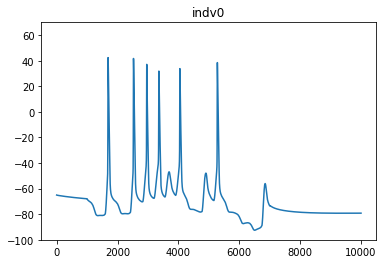

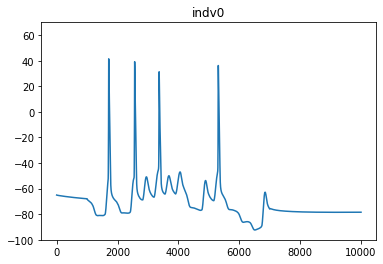

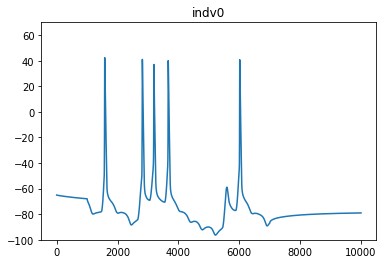

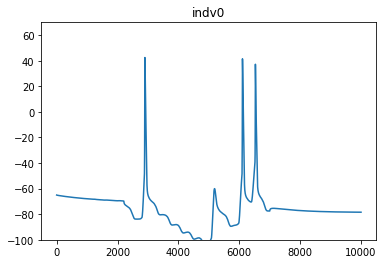

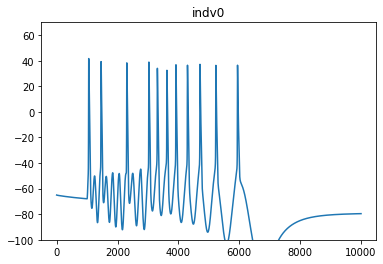

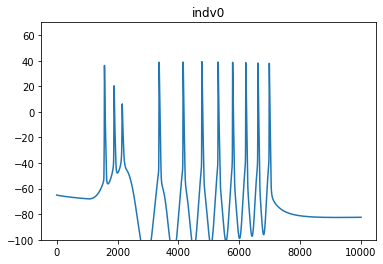

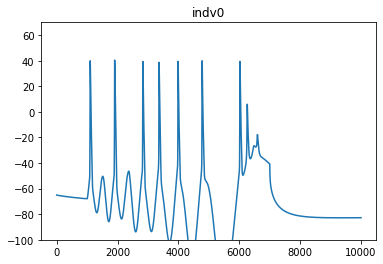

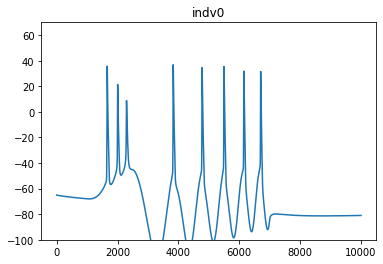

In [3]:
for i in range(0,8): #Nstims here
    #curr_volts = nrnMreadH5(data_dir + '/VHotP' + str(i)  + '.h5')
    curr_volts = np.genfromtxt("../Data/target_volts_BBP19.csv",delimiter = ',')[i,:]
    curr_times = np.genfromtxt(data_dir + '/times' + str(i) + '.csv', delimiter =',')
    Nt = int(len(curr_volts)/len(curr_times))
    shaped_volts = np.reshape(curr_volts, [Nt,len(curr_times)])
    print(shaped_volts.shape)
    print(len(curr_volts))
    times = shaped_volts.shape[0]
    
    
    for indv in range(0,1): # range of individuals here
        plt.figure()
        plt.plot(np.arange(len(curr_times)),shaped_volts[indv,:])
        plt.title("indv" + str(indv))
        plt.ylim(-100,70)

print("population len:" ,Nt)
print(np.max(shaped_volts))
plt.show()


In [3]:
import h5py

run_volts_path = '../run_volts_bbp_full_gpu_tuned/'
paramsCSV = run_volts_path+'params/params_bbp_full_gpu_tuned_10_based.csv'
orig_params = h5py.File(run_volts_path+'params/params_bbp_full_allen_gpu_tune.hdf5', 'r')['orig_full'][0]
scores_path = '../scores/'
objectives_file = h5py.File('../python/objectives/multi_stim_bbp_full_allen_gpu_tune_18_stims.hdf5', 'r')
opt_weight_list = objectives_file['opt_weight_list'][:]
opt_stim_name_list = objectives_file['opt_stim_name_list'][:]
score_function_ordered_list = objectives_file['ordered_score_function_list'][:]
stims_path = run_volts_path+'/stims/allen_data_stims_10000.hdf5'
target_volts_path = '../python/target_volts/allen_data_target_volts_10000.hdf5'
target_volts_hdf5 = h5py.File(target_volts_path, 'r')
opt_stim_list = [e.decode('ascii') for e in opt_stim_name_list]
target_volts_list = np.array([target_volts_hdf5[s][:] for s in opt_stim_name_list])

for i in range(0,18):
    plt.figure()
    plt.plot(target_volts_list[i,:])

OSError: Unable to open file (unable to open file: name = '../run_volts_bbp_full_gpu_tuned/params/params_bbp_full_allen_gpu_tune.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [5]:
import pandas as pd

def readParamsCSV(fileName):
    fields = ['Param name', 'Base value','Lower bound', 'Upper bound']
    df = pd.read_csv(fileName,skipinitialspace=True, usecols=fields)
    
    paramsList = [tuple(x) for x in df.values]
    return paramsList

In [6]:
import bluepyopt as bpop

opt_ind = np.arange(24) 
data = readParamsCSV(paramsCSV)
data = np.array([data[i] for i in opt_ind])
pmin = np.array((data[:,2]), dtype=np.float64)
pmax = np.array((data[:,3]), dtype=np.float64)
# make this a function
fixed = {}
params = []
for param_idx in range(len(orig_params)):
    if np.isclose(orig_params[param_idx],pmin[param_idx],rtol=.001) and np.isclose(pmin[param_idx],pmax[param_idx],rtol=.001):
        print(orig_params[param_idx], " idx : ", param_idx)
        fixed[param_idx] = orig_params[param_idx]
    else:
        params.append(bpop.parameters.Parameter(orig_params[param_idx], bounds=(pmin[param_idx],pmax[param_idx])))

8e-05  idx :  0
0.00291  idx :  7
287.198731  idx :  13
0.000609  idx :  15
210.485284  idx :  21


In [7]:
   # convert the allen data and save as csv
import csv
ntimestep = 100000
def convert_allen_data():
    """
    Function that sets up our new allen data every run. It reads and writes every stimi
    and timesi and removes previous ones. Using csv writer to write timesi so it reads well.
    """
    for i in range(len(opt_stim_name_list)):
        old_stim = "../Data/Stim_raw{}.csv"
        old_time = "../Data/times_{}.csv"
        if os.path.exists(old_stim) :
            os.remove(old_stim)
            os.remove(old_time)
    for i in range(len(opt_stim_name_list)):
        stim = opt_stim_name_list[i].decode("utf-8")
        dt = .02 # refactor this later to be read or set to .02 if not configured
        f = open ("../Data/times{}.csv".format(i), 'w')
        wtr = csv.writer(f, delimiter=',', lineterminator='\n')
        current_times = [dt for i in range(ntimestep)]
        wtr.writerow(current_times)
        f.close()
        np.savetxt("../Data/Stim_raw{}.csv".format(i), 
                   stim_file[stim][:],
                   delimiter=",")


In [8]:
def run_model(stim_ind):
    """
    Parameters
    -------------------------------------------------------
    stim_ind: index to send as arg to neuroGPU 
    params: DEPRECATED remove

    Returns
    ---------------------------------------------------------
    p_object: process object that stops when neuroGPU done
    """
    global_rank = 0
    volts_fn = vs_fn + str(stim_ind) + '.dat'
    if os.path.exists(volts_fn):
        #print("removing ", volts_fn, " from ", global_rank)
        os.remove(volts_fn)
    cmd = 'ls -l'
    !{'cd ..'}
    #!{'../bin/neuroGPU'+str(global_rank),str(stim_ind), str(global_rank)}
    p_object = subprocess.Popen(['../bin/neuroGPU',str(stim_ind)],
                    stdout=subprocess.PIPE, 
                    stderr=subprocess.STDOUT,  # <-- redirect stderr to stdout
                    bufsize=1)
    print(p_object, stim_ind)
    with p_object.stdout:
        for line in iter(p_object.stdout.readline, b''):
            print(line),
    p_object.wait()
    print(p_object.stderr)
    return p_object

In [9]:
def stim_swap(idx, i):
    """
    Stim swap takes 'idx' which is the stim index % 8 and 'i' which is the actual stim idx
    and then deletes the one at 'idx' and replaces it with the stim at i so that 
    neuroGPU reads stims like 13 as stim_raw5 (13 % 8)
    """
    old_stim = '../Data/Stim_raw' + str(idx) + '.csv'
    old_time = '../Data/times' + str(idx) + '.csv'
    if os.path.exists(old_stim):
        os.remove(old_stim)
        os.remove(old_time)
    os.rename(r'../Data/Stim_raw' + str(i) + '.csv', r'../Data/Stim_raw' + str(idx) + '.csv')
    os.rename(r'../Data/times' + str(i) + '.csv', r'../Data/times' + str(idx) + '.csv')


In [10]:
def getVolts(idx):
    '''Helper function that gets volts from data and shapes them for a given stim index'''
    fn = vs_fn + str(idx) +  '.h5'    #'.h5' 
    curr_volts =  nrnMreadH5(fn)
    #fn = vs_fn + str(idx) +  '.dat'    #'.h5'
    #curr_volts =  nrnMread(fn)
    Nt = int(len(curr_volts)/ntimestep)
    shaped_volts = np.reshape(curr_volts, [Nt,ntimestep])
    return shaped_volts

In [ ]:
for i in range(len(opt_stim_name_list)):
        stim = opt_stim_name_list[i].decode("utf-8")
        plt.figure()
        plt.plot(stim_file[stim][:])

In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pickle
from extractModel_mappings_linux import   allparams_from_mapping
import subprocess

paramsCSV = '../params/params_bbp_full.csv'
#orig_params = np.array(np.array(nrnUtils.readParamsCSV(paramsCSV))[:,1], dtype=np.float64)
orig_params = h5py.File('../params/params_bbp_full.hdf5', 'r')['orig_full'][0]
print(orig_params.shape)
scores_path = '../scores/'
objectives_file = h5py.File('../objectives/multi_stim_bbp_full.hdf5', 'r')
opt_weight_list = objectives_file['opt_weight_list'][:]
opt_stim_name_list = objectives_file['opt_stim_name_list'][:]
opt_stim_list = [e.decode('ascii') for e in opt_stim_name_list]
score_function_ordered_list = objectives_file['ordered_score_function_list'][:]
stims_path = '../stims/stims_full.hdf5'
stim_file = h5py.File(stims_path, 'r')
#target_volts_path = './target_volts/allen_data_target_volts_10000.hdf5'
#target_volts_hdf5 = h5py.File(target_volts_path, 'r')
#params_opt_ind = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
params_opt_ind = np.arange(24) 
model_dir = '..'
data_dir = model_dir+'/Data/'
run_dir = '../bin'
vs_fn = '/tmp/Data/VHotP'
target_volts = np.genfromtxt("../Data/target_volts_BBP19.csv",delimiter = ',')

#paramset = np.array(pickle.load( open( "../python/best_indv_logs/best_indvs_gen_10.pkl", "rb" ) ))
paramset = np.array(pickle.load( open( "../python/best_indvs_final_31_Oct_2020.pkl", "rb" ) ))
for reinsert_idx in fixed.keys():
    paramset = np.insert(np.array(paramset), reinsert_idx, fixed[reinsert_idx], axis = 1)

print(paramset[0])
print(orig_params)

nstims = len(opt_stim_list)
convert_allen_data()
allparams_from_mapping(paramset)
for i in range(0,nstims):
    if i != 0:
        p_object = run_model(0)
        p_object.wait()
        getVolts(0)
        stim_swap(0,i)
    
    
print(1/0)
for i in range(0,18):
    plt.figure()
    plt.plot(target_volts[i,:])

(24,)
[8.00000000e-05 1.79922692e+00 2.01434217e-01 4.01899484e-03
 8.64794342e-03 2.23438361e+02 3.33848302e+00 2.91000000e-03
 5.81758859e-01 3.49159080e-01 1.36222981e-02 1.88224327e+01
 3.30357316e+00 2.87198731e+02 6.69145013e-01 6.09000000e-04
 4.58629921e-01 2.26931594e-01 4.10624101e-02 7.30480739e+01
 7.90595674e-03 2.10485284e+02 2.52347670e-02 1.98689132e-04]
[8.00000000e-05 2.61450000e-02 4.22600000e-03 8.00000000e-05
 1.43000000e-04 3.13796800e+00 8.92590000e-02 2.91000000e-03
 6.82700000e-03 7.10400000e-03 9.90000000e-04 9.73538000e-01
 1.02194500e+00 2.87198731e+02 8.75200000e-03 6.09000000e-04
 3.03472000e-01 8.40700000e-03 9.94000000e-04 9.83955000e-01
 8.00000000e-05 2.10485284e+02 3.33000000e-04 3.00000000e-05]
<subprocess.Popen object at 0x2aaad9377fd0> 0
b'../bin/neuroGPU: error while loading shared libraries: libhdf5_hl_cpp.so.100: cannot open shared object file: No such file or directory\n'
None


OSError: Unable to open file (unable to open file: name = '/tmp/Data/VHotP0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [16]:
!module unload darshan/3.1.7
!module list

Currently Loaded Modulefiles:
  1) modules/3.2.11.4
  2) altd/2.0
  3) darshan/3.1.7
  4) intel/19.0.3.199
  5) craype-network-aries
  6) craype/2.6.2
  7) cray-libsci/19.06.1
  8) udreg/2.3.2-7.0.1.1_3.36__g8175d3d.ari
  9) ugni/6.0.14.0-7.0.1.1_7.38__ge78e5b0.ari
 10) pmi/5.0.14
 11) dmapp/7.1.1-7.0.1.1_4.52__g38cf134.ari
 12) gni-headers/5.0.12.0-7.0.1.1_6.31__g3b1768f.ari
 13) xpmem/2.2.20-7.0.1.1_4.13__g0475745.ari
 14) job/2.2.4-7.0.1.1_3.40__g36b56f4.ari
 15) dvs/2.12_2.2.157-7.0.1.1_9.4__g083131db
 16) alps/6.6.58-7.0.1.1_6.8__g437d88db.ari
 17) rca/2.2.20-7.0.1.1_4.51__g8e3fb5b.ari
 18) atp/2.1.3
 19) PrgEnv-intel/6.0.5
 20) craype-haswell
 21) cray-mpich/7.7.10
 22) craype-hugepages2M
 23) esslurm


In [7]:
!module load hdf5-parallel


hdf5-parallel/1.10.5-pgi(17):ERROR:150: Module 'hdf5-parallel/1.10.5-pgi' conflicts with the currently loaded module(s) 'darshan/3.1.7'
hdf5-parallel/1.10.5-pgi(17):ERROR:102: Tcl command execution failed: conflict darshan



In [4]:
for i in range(600):
    if max(shaped_volts[i,:]) > 20:
        print(i)

195
227


In [ ]:
import h5py
objectives_file = h5py.File('../python/objectives/multi_stim_bbp_full_allen_gpu_tune_18_stims.hdf5', 'r')

allen_stim_file = h5py.File('../run_volts_bbp_full_gpu_tuned/stims/allen_data_stims_10000.hdf5', 'r')
opt_stim_name_list = objectives_file['opt_stim_name_list'][:]
stims = list([e.decode('ascii') for e in opt_stim_name_list])[:]
score_function_ordered_list = objectives_file['ordered_score_function_list'][:]
for stim in stims:
    plt.figure()
    plt.plot(allen_stim_file[stim][:])

# Score one set of stim!

In [ ]:
res = map_par(0,6)
res1 = map_par(6,12)
res2 = map_par(12,18)
full_res = map_par(0,18)

In [ ]:
final = np.sum(res, axis=1) + np.sum(res1, axis=1) + np.sum(res2, axis=1)
print(final)
np.sum(full_res, axis =1)

In [ ]:
from multiprocessing import Pool
import multiprocessing
import bluepyopt as bpop
import h5py
import score_functions as sf

##########SET THESE############
nGpus = 6
nCpus =  multiprocessing.cpu_count()
first_individual = 0
last_individual = 1

first_stim = 0
last_stim = 3
###############################
objectives = [bpop.objectives.Objective('Weighted score functions')]
run_file = './run_model_cori.hoc'
run_volts_path = '../run_volts_bbp_full_gpu_tuned/'
paramsCSV = run_volts_path+'params/params_bbp_full_gpu_tuned_10_based.csv'
orig_params = h5py.File(run_volts_path+'params/params_bbp_full_allen_gpu_tune.hdf5', 'r')['orig_full'][0]
scores_path = '../scores/'
objectives_file = h5py.File('../python/objectives/multi_stim_bbp_full_allen_gpu_tune_18_stims.hdf5', 'r')
opt_weight_list = objectives_file['opt_weight_list'][:]
weights = opt_weight_list
opt_stim_name_list = objectives_file['opt_stim_name_list'][:]
opt_stim_list = [e.decode('ascii') for e in opt_stim_name_list]
target_volts_path = '../python/target_volts/allen_data_target_volts_10000.hdf5'
target_volts_hdf5 = h5py.File(target_volts_path, 'r')
target_volts_list = np.array([target_volts_hdf5[s][:] for s in opt_stim_list])
allen_stim_file = h5py.File('../run_volts_bbp_full_gpu_tuned/stims/allen_data_stims_10000.hdf5', 'r')
model_dir = '..'
data_dir = model_dir+'/Data/'
run_dir = '../bin'
vs_fn = model_dir + '/Data/VHotP'
ntimestep = 10000
score_function_ordered_list = objectives_file['ordered_score_function_list'][:]
dts = [allen_stim_file[stim.decode("utf-8") + '_dt'][:][0] for stim in opt_stim_name_list] 
custom_score_functions = [
                    'chi_square_normal',\
                    'traj_score_1',\
                    'traj_score_2',\
                    'traj_score_3',\
                    'isi',\
                    'rev_dot_product',\
                    'KL_divergence']

# Number of timesteps for the output volt.
ntimestep = 10000

stim_names = list([e.decode('ascii') for e in opt_stim_name_list])
stims = []
for stim_name in stim_names:
    stims.append(allen_stim_file[stim_name][:])

    
    
def get_first_zero(stim):
    """Kyung helper function to penalize AP where there should not be one"""
    for i in range(len(stim)-2, -1, -1):
        if stim[i] > 0 and stim[i+1] == 0:
            return i+1
    return None

def check_ap_at_zero(stim_ind, volts):
    """
    Kyung function to check if a volt should be penalized for having an AP before there 
    should be one. Modified to take in "volts" as a list of individuals instead of "volt"
    """
    stim = stims[stim_ind]
    first_zero_ind = get_first_zero(stim)
    nindv =volts.shape[0]
    checks = np.zeros(len(range(last_individual -first_individual)))
    for i in range(first_individual,last_individual):
        volt = volts[i,:]
        if first_zero_ind:
            if np.mean(stim[first_zero_ind:]) == 0:
                first_ind_to_check = first_zero_ind + 1000
                APs = [True if v > 0 else False for v in volt[first_ind_to_check:]]
                if True in APs:
                    #return 400 # threshold parameter that I am still tuning
                    #print("indv:",i, "stim ind: ", stim_ind)
                    checks[i] = 0
    return checks    
    
    
def getVolts(idx):
    '''Helper function that gets volts from data and shapes them for a given stim index'''
    #print( "asking for volts:", idx, " from rank: ", idx)

    fn = vs_fn + str(idx) +  '.dat'    #'.h5'
    curr_volts =  nrnMread(fn)
    Nt = int(len(curr_volts)/ntimestep)
    shaped_volts = np.reshape(curr_volts, [Nt,ntimestep])
    return shaped_volts

def normalize_scores(curr_scores, transformation,i):
    '''changed from hoc eval so that it returns normalized score for list of indvs, not just one
    TODO: not sure what transformation[6] does but I changed return statement to fit our 
    dimensions'''
    # transformation contains: [bottomFraction, numStds, newMean, std, newMax, addFactor, divideFactor]
    # indices for reference:   [      0       ,    1   ,    2   ,  3 ,    4  ,     5    ,      6      ]
    for i in range(len(curr_scores)):
        if curr_scores[i] > transformation[4]:
            curr_scores[i] = transformation[4]        # Cap newValue to newMax if it is too large
    normalized_single_score = (curr_scores + transformation[5])/transformation[6]  # Normalize the new score
    if transformation[6] == 0:
        #return 1
        return 1/0##np.ones(len(self.nindv)) #verify w/ Kyung
    return normalized_single_score

def eval_stim_sf_pair(perm):
    """ 
    function that evaluates a stim and score function pair on line 252. Sets i as the actual 
    index and and mod_i as it's adjusted index (should get 15th target volt but that will 
    be 7th in the data_volts_list). transform then normalize and then multiply by weight
    and then SENT BACK to MAPPER. uses self. for weights, data_volts, and target volts because
    it is easy information transfer instead of passing arguments into map.

    Arguments
    --------------------------------------------------------------------
    perm: pair of ints where first is the stim and second is the score function label index
    to run

    Returns
    ---------------------------------------------------------------------
    scores: normalized+weighted scores with the shape (nindv, 1), and sends them back to map
    to be stacked then summed.

    """
    i = perm[0]
    j = perm[1]
    counter = 0
    curr_data_volt = getVolts(i)#[:,:] 
    curr_target_volt = target_volts_list[i]
    curr_sf = score_function_ordered_list[j].decode('ascii')
    curr_weight = weights[len(score_function_ordered_list)*i + j]
    transformation = h5py.File(scores_path+opt_stim_list[i]+'_scores.hdf5', 'r')['transformation_const_'+curr_sf][:]
    if curr_sf in custom_score_functions:
        score = [getattr(sf, curr_sf)(curr_target_volt, curr_data_volt[indv,:], dts[i]) for indv in range(first_individual, last_individual)]
    else:
        score = sf.eval_efel(curr_sf, curr_target_volt, curr_data_volt[first_individual:last_individual, :], dts[i])
    curr_scores =  score #+ check_ap_at_zero(i, curr_data_volt)# here is I am adding penalty
    norm_scores = normalize_scores(curr_scores, transformation, i)
    for k in range(len(norm_scores)):
        if np.isnan(norm_scores[k]):
            norm_scores[k] = 1
    return norm_scores * curr_weight #+ check_ap_at_zero(i, curr_data_volt)# here is I am adding penalty




def top_SFs(first_stim, last_stim):
    """
    finds scoring functions w/ weight over 50 and pairs them with that stim and sends
    them to mapping function so that we will run so many processes
    """
    all_pairs = []
    for i in range(first_stim, last_stim):#range(first_stim,last_stim):
        sf_len = len(score_function_ordered_list)
        curr_weights = weights[sf_len*i: sf_len*i + sf_len] #get range of sfs for this stim
        #top_inds = sorted(range(len(curr_weights)), key=lambda i: curr_weights[i], reverse=True)[:10] #finds top ten biggest weight indices
        top_inds = np.where(curr_weights > 50)[0] # weights bigger than 50
        pairs = list(zip(np.repeat(i,len(top_inds)), [ind for ind in top_inds])) #zips up indices with corresponding stim # to make sure it is refrencing a relevant stim
        all_pairs.append(pairs)
    flat_pairs = [pair for pairs in all_pairs for pair in pairs] #flatten the list of tuples
    return flat_pairs

def map_par(first_stim, last_stim):
    ''' 
    This function maps out what stim and score function pairs should be mapped to be evaluated in parallel
    first it finds the pairs with the highest weights, the maps them and then adds up the score for each stim
    for every individual.


    Return
    --------------------
    2d list of scalar scores for each parameter set w/ shape (nindv,nstims)
    '''
    #comm.Barrier() # so all workers do mapping at the same time
    fxnsNStims = top_SFs(first_stim, last_stim) # 52 stim-sf combinations (stim#,sf#)   
    print(fxnsNStims)
    ##OPTIONS FOR PARALLELISM FOR NOW
    #MPI Version
    #executor = MPIPoolExecutor()
    #res = executor.map(self.eval_stim_sf_pair, fxnsNStims)
    #joblib
    #res = Parallel(n_jobs=nCpus, prefer="threads")(delayed(self.eval_stim_sf_pair)(FnS) for FnS in fxnsNStims)
    #multiproc / concurrent future
    with Pool(nCpus) as p:
        res = p.map(eval_stim_sf_pair, fxnsNStims)
    res = np.array(list(res)) ########## important: map returns results with shape (# of sf stim pairs, nindv)
    res = res[:,:]
    print((res.shape), "res shape")
    prev_sf_idx = 0 
    # get first and last stim so we cna iterate through them and make their scores from mapping
#     last_stim = (rank+1) * nGpus # ie: 0th rank last_stim = (0+1)*ngpus = ngpus
#     first_stim = last_stim - nGpus
    for i in range(first_stim, last_stim):  # iterate stims and sum
        num_curr_sfs = sum([1 for pair in fxnsNStims if pair[0]==i]) #find how many sf indices for this stim
        #print([pair for pair in fxnsNStims if pair[0]==i], "PAIRS for stim :" , i)
        AP_penalty = check_ap_at_zero(i, getVolts(i))
        if i == first_stim:
            weighted_sums = np.reshape(np.sum(res[prev_sf_idx:prev_sf_idx+num_curr_sfs, :], axis=0) + AP_penalty ,(-1,1))
        else:
            #print(np.sum(res[prev_sf_idx:prev_sf_idx+num_sfs, :], axis=0), "SUM for sfs", num_sfs, prev_sf_idx  )
            curr_stim_sum = np.reshape(np.sum(res[prev_sf_idx:prev_sf_idx+num_curr_sfs, :], axis=0) + AP_penalty, (-1,1))
            #print(min(curr_stim_sum[:,0]), "MIN SCORE FOR STIM", i)
            weighted_sums = np.append(weighted_sums, curr_stim_sum , axis = 1)
            #print(min(weighted_sums),"sums min")
            #print(fxnsNStims[prev_sf_idx:prev_sf_idx+num_curr_sfs], "FXNS BEING SUMMED at ", i)
            #print(prev_sf_idx, num_sfs, len(fxnsNStims))

        prev_sf_idx = prev_sf_idx + num_curr_sfs # update score function tracking index
    return weighted_sums

    

# Plot Params

In [ ]:
#start running neuroGPU
full_params = [ 4.56063252e-06, -6.66000000e+01,  4.11901440e+00,  1.72523876e+00,
  1.19270009e-01,  1.07414161e+01,  5.02302505e+00,  1.11933994e-01,
  8.61572637e-04,  5.08566528e-02,  3.06692579e-03,  1.17344498e+01,
  6.00026564e-04,  2.20472008e-03]
nGpus = 6

from extractModel_mappings_linux import   allparams_from_mapping
import subprocess
model_dir = '..'
data_dir = model_dir+'/Data'
run_dir = '../bin'
vs_fn = model_dir + '/Data/VHotP'

########################################################################################
# run this from GPU node and set these values
stim_range = np.arange(4) # currently only supports stims 0
####################################################################################

full_params = np.array(full_params).reshape(1,-1)
allparams = allparams_from_mapping(list(full_params))
p_objects = []
for stim_num in stim_range:
    adjusted_ind = stim_num % nGpus
    p_objects.append(run_model(adjusted_ind))
# for stim_num in stim_range:
#     mod_stim_num = stim_num % (nGpus)
#     p_objects[mod_stim_num].wait() #wait to get volts output from previous run then read and stack

In [38]:
def run_model(stim_ind):
    """
    Parameters
    -------------------------------------------------------
    stim_ind: index to send as arg to neuroGPU 
    params: DEPRECATED remove

    Returns
    ---------------------------------------------------------
    p_object: process object that stops when neuroGPU done
    """
    global_rank = 0
    if os.path.exists(volts_fn):
        #print("removing ", volts_fn, " from ", global_rank)
        os.remove(volts_fn)
    cmd = 'ls -l'
    !{'cd ..'}
    #!{'../bin/neuroGPU'+str(global_rank),str(stim_ind), str(global_rank)}
    p_object = subprocess.Popen(['../bin/neuroGPU',str(stim_ind)],
                    stdout=subprocess.PIPE, 
                    stderr=subprocess.STDOUT,  # <-- redirect stderr to stdout
                    bufsize=1)
    print(p_object, stim_ind)
    with p_object.stdout:
        for line in iter(p_object.stdout.readline, b''):
            print(line),
    p_object.wait()
    print(p_object.stderr)
    return p_object

In [ ]:
for i in stim_range: #Nstims
    curr_volts = nrnMread(data_dir + '/VHotP' + str(i)  + '.dat')
    curr_times = np.genfromtxt(data_dir + '/times' + str(i) + '.csv', delimiter =',')
    Nt = int(len(curr_volts)/len(curr_times))
    shaped_volts = np.reshape(curr_volts, [Nt,len(curr_times)])
    print(shaped_volts.shape)
    print(len(curr_volts))
    times = shaped_volts.shape[0]
    
    
    for indv in range(0,1):
        plt.figure()
        plt.plot(np.arange(len(curr_times)),shaped_volts[indv,:])
        plt.title("indv" + str(indv))
        plt.ylim(-70,70)

#plt.ylim(bottom=ymin) #ymin is your value
print("population len:" ,Nt)
print(np.max(shaped_volts))
plt.show()

In [ ]:
np.isnan(shaped_volts[0,:].any())